In [47]:
import time
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA

import requests
import matplotlib.pyplot as plt
import seaborn as sns

### Спарсим данные, сохраним полученные датафреймы и будем в случае чего обращаться к локально сохраненным данным

In [7]:
# Парсер для получения данных с westmetall
def parser(metall_str: str):
    url = f'https://www.westmetall.com/en/markdaten.php?action=table&field=LME_{metall_str}_cash'
        
    response = requests.get(url=url)
    
    # преобразуем ответ в датафрейм
    df_2023 = pd.read_html(response.text)[0]
    df_2022 = pd.read_html(response.text)[1]
    df_2021 = pd.read_html(response.text)[2]
    df_2020 = pd.read_html(response.text)[3]
    df_2019 = pd.read_html(response.text)[4]
    df_2018 = pd.read_html(response.text)[5]
    df_2017 = pd.read_html(response.text)[6]
    df_2016 = pd.read_html(response.text)[7]
    df_2015 = pd.read_html(response.text)[8]
    df_2014 = pd.read_html(response.text)[9]
    df_2013 = pd.read_html(response.text)[10]
    
    df = pd.concat([
        df_2023, df_2022, df_2021, 
        df_2020, df_2019, df_2018, 
        df_2017, df_2016, df_2015,
        df_2014, df_2013
    ]
    )
    
    # очищаем таблицу от неинформативных строк
    cleared_df = df[df['date'] != 'date']
    # заменяем символы пропусков нулями
    cleared_df = cleared_df.replace('-', 0)
    
    # приобразуем типы данных
    cleared_df['date'] = pd.to_datetime(cleared_df['date'])
    # т.к. столбцы имеют разное назание, обращяемся по индексу
    cleared_df.iloc[:,1] = pd.to_numeric(
        cleared_df.iloc[:,1])

    cleared_df.iloc[:,2] = pd.to_numeric(
        cleared_df.iloc[:,2])
    # в данном столбце, за счет использования символа запятой
    # для разделения целой части от дробной,
    # pandas не корректно преобразовал значения
    cleared_df.iloc[:,3] = pd.to_numeric(
        cleared_df.iloc[:,3]) / 1000
    
    return cleared_df.set_index('date')

# Список источников, нам понадобится информация по 5 видам сырья:
# алюминий, медь, свинец, никель и цинк
metalls = ['Al', 'Cu', 'Pb', 'Ni', 'Zn']

# Иниуиируем датафреймы, делая паузу после исполнения, для обхода
# возможной блокировки со стороны источника
al_df = parser(metalls[0])
time.sleep(1)
cu_df = parser(metalls[1])
time.sleep(1)
pb_df = parser(metalls[2])
time.sleep(1)
ni_df = parser(metalls[3])
time.sleep(1)
zn_df = parser(metalls[4])

In [8]:
# Выведем полученные данные и сохраним как бекап.
al_df.to_csv('./data/aluminium.csv', sep=',')
cu_df.to_csv('./data/copper.csv', sep=',')
pb_df.to_csv('./data/lead.csv', sep=',')
ni_df.to_csv('./data/nickel.csv', sep=',')
zn_df.to_csv('./data/zink.csv', sep=',')

display(cu_df.head(), cu_df.head())

,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
date,,,
2023-09-12,8337.5,8365.0,135.65
2023-09-11,8332.5,8360.0,134.525
2023-09-08,8225.0,8242.0,134.125
2023-09-07,8242.5,8270.0,133.85
2023-09-06,8395.0,8412.0,110.4


,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
date,,,
2023-09-12,8337.5,8365.0,135.65
2023-09-11,8332.5,8360.0,134.525
2023-09-08,8225.0,8242.0,134.125
2023-09-07,8242.5,8270.0,133.85
2023-09-06,8395.0,8412.0,110.4


In [ ]:
# Парсер для Nasdaq к сожалению уперся в защиту, потому было решено вытащить руками json с историческими данными
with open('./data/HGCMX.json') as file:
    data = json.load(file)

# Этап обработки полученных данных 
trades = data['data']['tradesTable']['rows']
df_hgcmx = pd.DataFrame(trades)
df_hgcmx['date'] = pd.to_datetime(df_hgcmx['date'])
df_hgcmx['volume'] = df_hgcmx['volume'].str.replace(',', '.')
df_hgcmx = df_hgcmx.replace('N/A', 0)
df_hgcmx = df_hgcmx[['date', 'close', 'volume']]
df_hgcmx['close'] = pd.to_numeric(df_hgcmx['close'])
df_hgcmx['volume'] = pd.to_numeric(df_hgcmx['volume'])
# Сохраним df с которым будем в последствие работать
df_hgcmx.to_csv('./data/HGCMX.csv', sep=',') 

----

In [10]:
data_lme = pd.read_csv('./data/copper.csv', parse_dates=['date'], index_col='date')
data_lme = data_lme.sort_index()
data_lme


,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
date,,,
2013-01-02,8085.0,8112.0,320.500
2013-01-03,8140.5,8166.0,320.000
2013-01-04,8026.0,8060.0,320.225
2013-01-07,7995.5,8032.5,319.400
2013-01-08,8050.5,8085.5,327.375
...,...,...,...
2023-09-06,8395.0,8412.0,110.400
2023-09-07,8242.5,8270.0,133.850
2023-09-08,8225.0,8242.0,134.125


In [34]:
data_nasdaq = pd.read_csv('./data/HGCMX.csv', parse_dates=['date'], index_col='date')
data_nasdaq.drop(['Unnamed: 0'], inplace=True, axis=1)
data_nasdaq = data_nasdaq['volume']

In [35]:
data = pd.merge(data_lme, data_nasdaq, left_index=True, right_index=True)
data.replace(0, np.nan, inplace=True)
data.dropna(inplace=True, axis=0)
data.rename(columns={'volume': 'NASDAQ_volume', 'LME Copper stock': 'LME_stock'}, inplace=True)
data.head()

,LME Copper Cash-Settlement,LME Copper 3-month,LME_stock,NASDAQ_volume
date,,,,
2013-09-13,7028.5,7060.0,577.525,37.018
2013-09-16,7050.0,7085.0,574.675,41.387
2013-09-17,7056.5,7087.0,574.600,33.580
2013-09-18,7090.5,7118.0,571.950,50.190
2013-09-19,7301.5,7330.5,568.575,42.423


In [36]:
df_lme_stock = data['LME_stock']
df_lme_stock = df_lme_stock.resample('d').interpolate(method='linear')

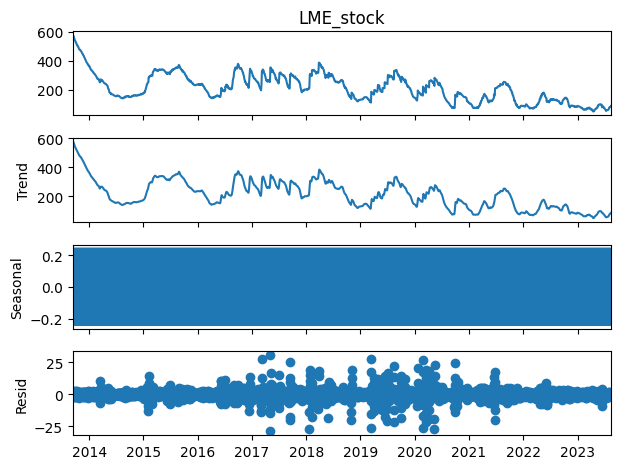

In [37]:
decomposition = seasonal_decompose(df_lme_stock)
fig = decomposition.plot()
plt.show()

In [38]:
df_nasdaq_stock = data['LME_stock']
df_nasdaq_stock = df_nasdaq_stock.resample('d').interpolate(method='linear')

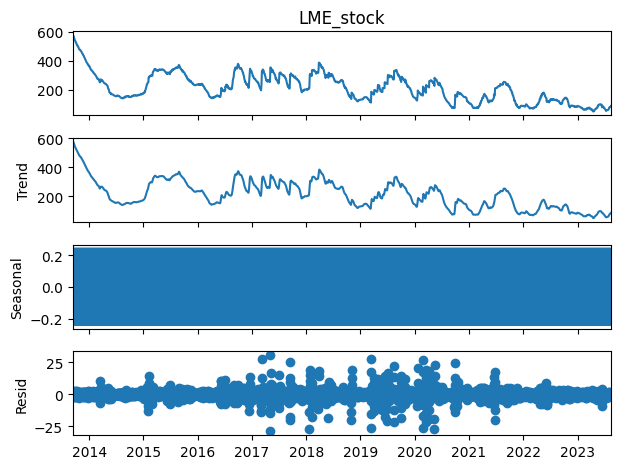

In [39]:
decomposition = seasonal_decompose(df_nasdaq_stock)
fig = decomposition.plot()
plt.show()

In [48]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, ax=axes[0], lags=40)
    sgt.plot_pacf(series, ax=axes[1], lags=40, method="ywm")
    plt.show()
    
    
def stat_test(df):
    test = sm.tsa.adfuller(df)
    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')


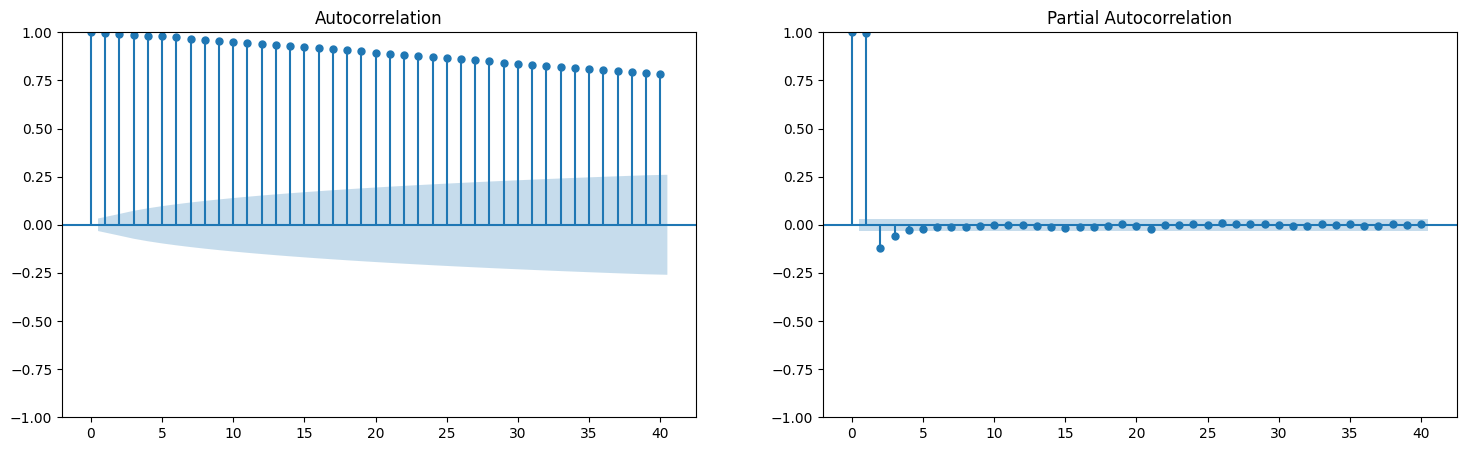

adf:  -3.729854904673605
p-value:  0.0037122862235929393
Critical values:  {'1%': -3.4321592195007473, '5%': -2.8623394121216172, '10%': -2.5671955395660633}
единичных корней нет, ряд стационарен


In [49]:
plot_acf_pacf(df_lme_stock)
stat_test(df_lme_stock)

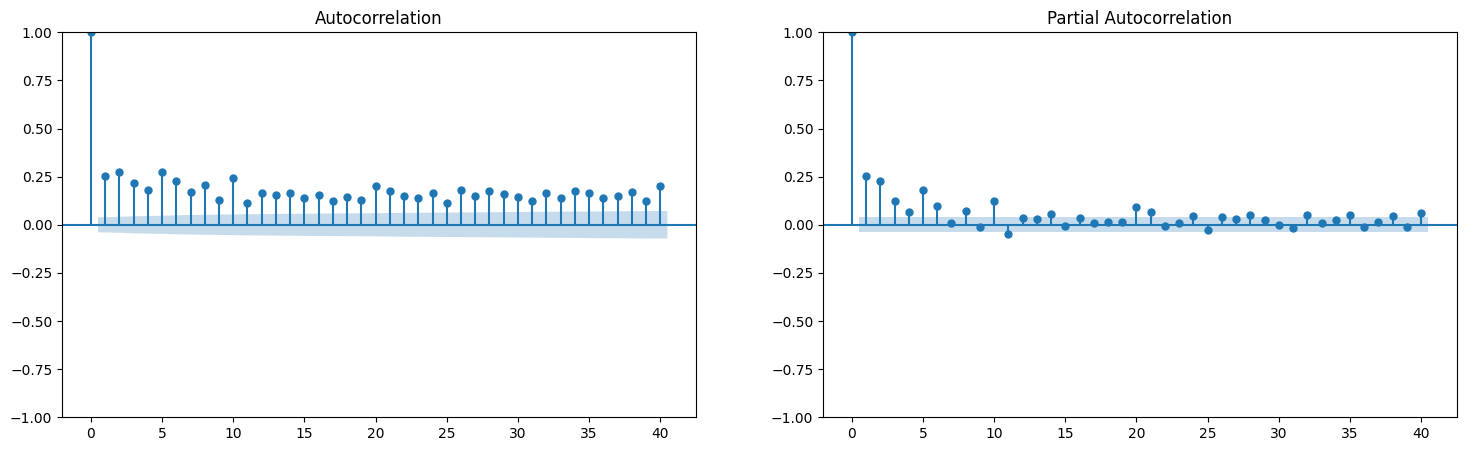

adf:  -4.644453997162575
p-value:  0.00010687393929841247
Critical values:  {'1%': -3.4329778809556224, '5%': -2.86270098200392, '10%': -2.5673880359934063}
единичных корней нет, ряд стационарен


In [50]:
plot_acf_pacf(data_nasdaq)
stat_test(data_nasdaq)

In [61]:
train_data = df_cu.loc['2015-01-02':'2023-05-31']
test_data = df_cu.loc['2023-06-01':]

train_data = train_data.sort_index()
test_data = test_data.sort_index()

train_data['LME Copper Cash-Settlement'] = pd.to_numeric(train_data['LME Copper Cash-Settlement'], errors='coerce')
train_data['LME Copper 3-month'] = pd.to_numeric(train_data['LME Copper 3-month'], errors='coerce')
train_data['LME Copper stock'] = pd.to_numeric(train_data['LME Copper stock'], errors='coerce')

test_data['LME Copper Cash-Settlement'] = pd.to_numeric(test_data['LME Copper Cash-Settlement'], errors='coerce')
test_data['LME Copper 3-month'] = pd.to_numeric(test_data['LME Copper 3-month'], errors='coerce')
test_data['LME Copper stock'] = pd.to_numeric(test_data['LME Copper stock'], errors='coerce')

KeyError: 'LME Copper Cash-Settlement'

In [229]:
# Создание и обучение модели ARIMA
model = ARIMA(train_data.iloc[:,2], order=(1, 0, 1))
model_fit = model.fit()

# Прогнозирование значений
forecast = model_fit.forecast(steps=len(test_data.iloc[:,2]))

# Оценка точности прогноза
mse = np.mean((forecast - test_data.iloc[:,2]) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(forecast - test_data.iloc[:,2]))

# Вывод результатов
print("RMSE:", rmse)
print("MAE:", mae)

RMSE: nan
MAE: nan


In [230]:
forecast

1113     99.246720
1114     99.587282
1115     99.925784
1116    100.262238
1117    100.596656
           ...    
1180    118.052365
1181    118.279155
1182    118.504572
1183    118.728625
1184    118.951323
Name: predicted_mean, Length: 72, dtype: float64

In [231]:
test_data

,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
date,,,
2023-06-01,8210.5,8227.0,99.525
2023-06-02,8337.0,8345.0,98.675
2023-06-05,8265.0,8263.0,98.950
2023-06-06,8311.0,8322.0,99.825
2023-06-07,8352.0,8354.0,100.100
...,...,...,...
2023-09-05,8430.0,8430.0,107.400
2023-09-06,8395.0,8412.0,110.400
2023-09-07,8242.5,8270.0,133.850
